# Signal processing lab: FIR & IIR filters

Frédéric Druppel, 18053  
2024-12-02

## Importing libraries

We will use the following libraries:
- `IPython.display` for audio playback
- `ipywidgets` for interactive widgets
- `librosa` for spectral analysis
- `matplotlib` for plotting
- `numpy` for numerical operations
- `scipy` for signal processing
- `soundfile` for reading and writing audio files

In [1]:
# Import libs

%matplotlib inline

from IPython import display as ipd
from IPython.display import display, Javascript
import ipywidgets as widgets
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
from scipy import *
import soundfile as sf


## Reading the input file

Let's look at the signal of our input file, and plot it in the time domain.

In [2]:
# Show audio player
ipd.Audio("Data/speech_three-tones.wav")

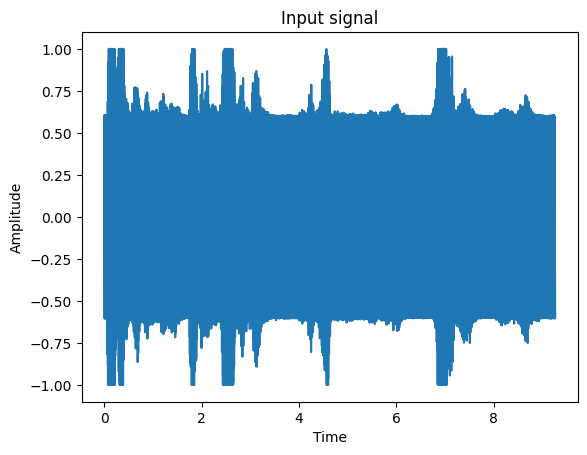

In [3]:
# Plot the input signal with matplotlib

# Read data
samples_mono, sampleRate = librosa.load('Data/speech_three-tones.wav', sr=None)

# Plot samples in time domain
time = np.arange(0, len(samples_mono)/sampleRate, 1/sampleRate)
plt.plot(time, samples_mono)
plt.title('Input signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

We can see a big block of noise during the whole signal, which makes the voice unintelligible.

Next, we can perform an FFT analysis of the whole signal to see the frequency content of the signal :

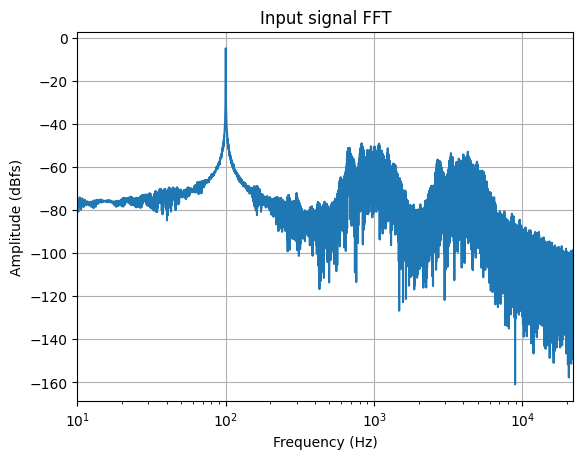

In [4]:
# Draw a FFT plot of the input signal using fft.fft
numSamples = len(samples_mono)
period = 1.0 / sampleRate
yf = fft.fft(samples_mono)
xf = fft.fftfreq(numSamples, period)[:numSamples//2]
yf = 2.0/numSamples * np.abs(yf[0:numSamples//2])
plt.plot(xf, 20*np.log10(yf))
plt.grid()
plt.xscale('log')
plt.xlim([10, sampleRate/2])
plt.title('Input signal FFT')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (dBfs)')
plt.show()

We can see a bih spike at 100Hz, a bump between 400 and 2000Hz, and another bump between 4000 and 8000Hz.

Let's show the spectrogram of the signal :

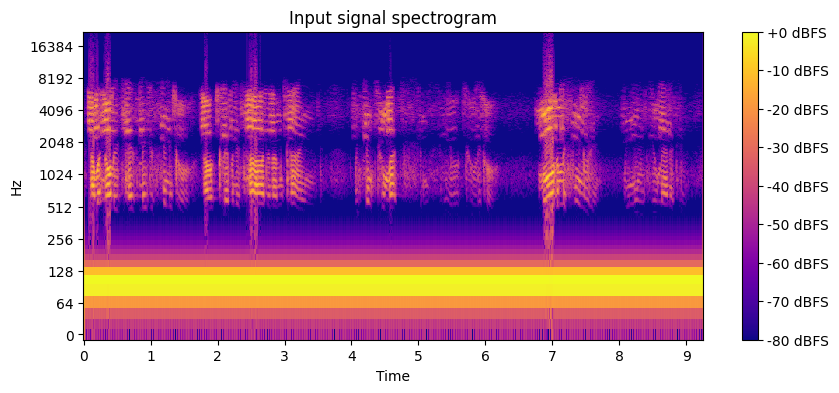

In [5]:
# Draw a spectrogram of the input signal

S = librosa.stft(samples_mono)
magnitude = np.abs(S)
S_dBFS = librosa.amplitude_to_db(magnitude, ref=np.max)

# Plot the spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_dBFS, sr=sampleRate, x_axis='time', y_axis='log', cmap='plasma')
plt.colorbar(format='%+2.0f dBFS')
plt.title('Input signal spectrogram')
plt.show()

We can confirm with the spectrogram that the spike at 100Hz is a constant noise source, that the bump between 400 and 2000Hz is the voice signal (deducted from faintly hearing a male voice), and the lump between 4000 and 8000Hz the translated voice signal (deducted from the shape in the spectrogram).  
We can also confirm that the interesting frequencies are between 400 and 2000Hz, as the telephone voice standard is between 300 and 3400Hz, which is enough for voice communication. Another way to confirm where the voice signal is to refer to HAM SSB communications, which have a bandwidth of 3kHz.

## FIR filter

Now that we know where the voice signal is, we can design a FIR filter to filter out the noise and keep the voice signal.

We'll use a bandpass FIR filter with a passband between 500Hz and 2000Hz. 

For the first filter, the amount of taps is calculated using the Kaiser formula.  
In our case we're using a 300Hz transition width, a 60dB attenuation, and a 44100Hz sampling rate.

In [ ]:
# FIR filter with automatically calculated taps
# Low pass filter at 3500Hz using firwin
low_cutoff = 500
high_cutoff = 2000

# The Nyquist rate of the signal.
nyq_rate = sampleRate / 2.0

# The desired width of the transition from pass to stop,
# relative to the Nyquist rate.  We'll design the filter
# with a x Hz transition width.
width = 300.0/nyq_rate

# The desired attenuation in the stop band, in dB.
stop_db = 60.0

# Compute the order and Kaiser parameter for the FIR filter.
numtaps, beta = signal.kaiserord(stop_db, width)
print('Amount of taps : ', numtaps)
auto_fir_filter = signal.firwin(numtaps, cutoff=[low_cutoff, high_cutoff], fs=sampleRate, pass_zero='bandpass', window=('kaiser', beta))


Amount of taps :  534


The automatic calculation gives us 534 taps, which is not a problem for computer hardware, but let's try to optimize the amount of taps for an embedded application (in our case 169 taps), using a Kaizer window once again.

In [ ]:
# FIR filter with set number of taps
# Low pass filter at 3500Hz using firwin
low_cutoff = 500
high_cutoff = 2000
numtaps = 169

# The Nyquist rate of the signal.
nyq_rate = sampleRate / 2.0

# The desired width of the transition from pass to stop,
# relative to the Nyquist rate.  We'll design the filter
# with a x Hz transition width.
width = 300.0/nyq_rate
# The desired attenuation in the stop band, in dB.
stop_db = 60.0

# Compute the order and Kaiser parameter for the FIR filter.
_, beta = signal.kaiserord(stop_db, width)

print('Amount of taps : ', numtaps)
set_fir_filter = signal.firwin(numtaps, cutoff=[low_cutoff, high_cutoff], fs=sampleRate, pass_zero='bandpass', window=('kaiser', beta))


Amount of taps :  169


Finally, let's play around with other window functions, to see if we can get a better result.

Gaussian window with a standard deviation of 2.2 :

In [8]:
# FIR filter with Gaussian window and set number of taps
# Low pass filter at 3500Hz using firwin
low_cutoff = 500
high_cutoff = 2000
numtaps = 169

std_dev = 2.2

# The Nyquist rate of the signal.
nyq_rate = sampleRate / 2.0

#print('Amount of taps : ', numtaps)
gaussian_fir_filter = signal.firwin(numtaps, cutoff=[low_cutoff, high_cutoff], fs=sampleRate, pass_zero='bandpass', window=('gaussian', std_dev))


Triangular window :

In [9]:
# FIR filter with Gaussian window and set number of taps
# Low pass filter at 3500Hz using firwin
low_cutoff = 500
high_cutoff = 2000
numtaps = 169

std_dev = 2.2

# The Nyquist rate of the signal.
nyq_rate = sampleRate / 2.0

#print('Amount of taps : ', numtaps)
trian_fir_filter = signal.firwin(numtaps, cutoff=[low_cutoff, high_cutoff], fs=sampleRate, pass_zero='bandpass', window='triang')


Square window :

In [10]:
# FIR filter with Gaussian window and set number of taps
# Low pass filter at 3500Hz using firwin
low_cutoff = 500
high_cutoff = 2000
numtaps = 169

std_dev = 2.2

# The Nyquist rate of the signal.
nyq_rate = sampleRate / 2.0

#print('Amount of taps : ', numtaps)
square_fir_filter = signal.firwin(numtaps, cutoff=[low_cutoff, high_cutoff], fs=sampleRate, pass_zero='bandpass', window='boxcar')


Let's see the plot of the transfer functions of the filters :

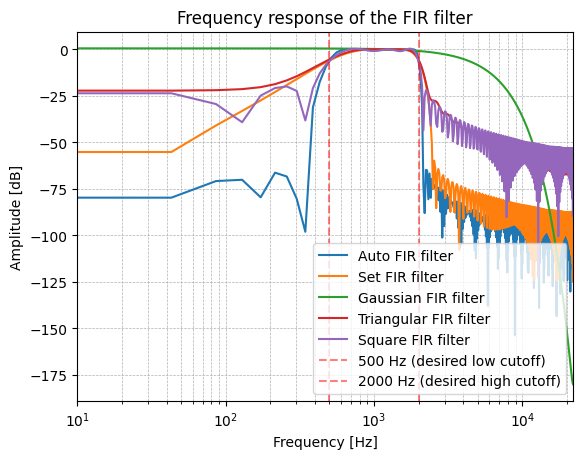

In [11]:
# Draw the frequency response of the filters
w, h = signal.freqz(auto_fir_filter)
w = w * sampleRate / (2 * np.pi)
plt.plot(w, 20 * np.log10(abs(h)), label="Auto FIR filter")
w, h = signal.freqz(set_fir_filter)
w = w * sampleRate / (2 * np.pi)
plt.plot(w, 20 * np.log10(abs(h)), label="Set FIR filter")
w, h = signal.freqz(gaussian_fir_filter)
w = w * sampleRate / (2 * np.pi)
plt.plot(w, 20 * np.log10(abs(h)), label="Gaussian FIR filter")
w, h = signal.freqz(trian_fir_filter)
w = w * sampleRate / (2 * np.pi)
plt.plot(w, 20 * np.log10(abs(h)), label="Triangular FIR filter")
w, h = signal.freqz(square_fir_filter)
w = w * sampleRate / (2 * np.pi)
plt.plot(w, 20 * np.log10(abs(h)), label="Square FIR filter")
plt.ylabel('Amplitude [dB]')
plt.xlabel('Frequency [Hz]')
plt.xscale('log')
plt.xlim([10, sampleRate/2])
plt.title('Frequency response of the FIR filter')
plt.axvline(500, color='red', linestyle='--', alpha=0.5, label='500 Hz (desired low cutoff)')
plt.axvline(2000, color='red', linestyle='--', alpha=0.5, label='2000 Hz (desired high cutoff)')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.legend(loc='lower right')
plt.show()

We can now see the transfer functions of the filters, and choose the filter that best fits our needs. Note that all the filters except the "Auto FIR Filter" have 169 taps. We can observe a lower performance in the stop-band region of the filters with 169 taps, though compromises can be made by choosing a different window function.

You can choose the filter with the following dropdown list, to listen to the filtered signal :

> Note : the cells after the dropdown have to be run again after changing the filter, as the audio player is not updated automatically.

In [12]:
# Filter dropdown selection

w = widgets.Dropdown(
    options=['No filter', 'Auto FIR filter', 'Set FIR filter', 'Gaussian FIR filter', 'Triangular FIR filter', 'Square FIR filter'],
    description='Filter :',
    value='Auto FIR filter',
)
filter_type = 'Auto FIR filter'

def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        global filter_type
        filter_type = change['new']

w.observe(on_change)

display(w)

Dropdown(description='Filter :', index=1, options=('No filter', 'Auto FIR filter', 'Set FIR filter', 'Gaussian…

In [13]:
# Apply the filter
if filter_type == 'No filter':
    filtered_signal = samples_mono
else :
    switcher = {
        'Auto FIR filter': auto_fir_filter,
        'Set FIR filter': set_fir_filter,
        'Gaussian FIR filter': gaussian_fir_filter,
        'Triangular FIR filter': trian_fir_filter,
        'Square FIR filter': square_fir_filter
    }
    filtered_signal = signal.lfilter(switcher.get(filter_type), 1.0, samples_mono)

# Save file
sf.write('Data/speech_three-tones_filtered_fir.wav', filtered_signal, sampleRate)

In [14]:
# Show audio player
ipd.Audio("Data/speech_three-tones_filtered_fir.wav")

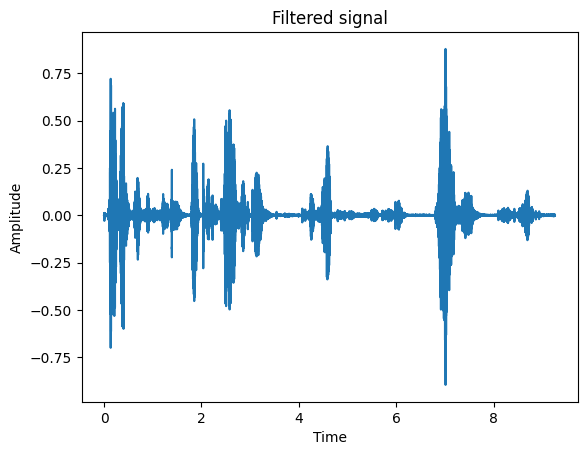

In [15]:
# Plot the filtered signal

fig, ax = plt.subplots()
ax.set_title('Filtered signal')
ax.set_xlabel('Time')
ax.set_ylabel('Amplitude')
time = np.arange(0, len(filtered_signal) / sampleRate, 1 / sampleRate)
line, = ax.plot(time, filtered_signal)
fig.canvas.draw_idle()

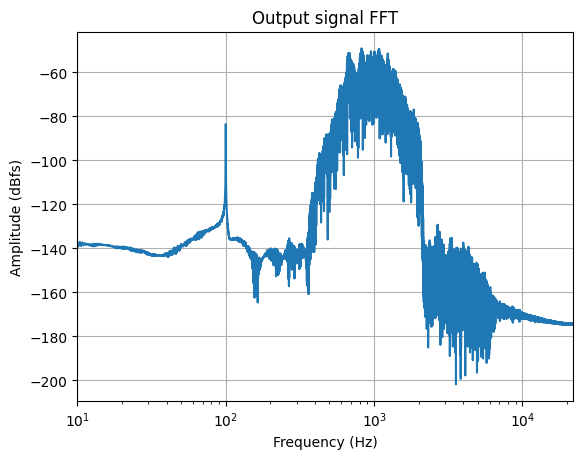

In [16]:
# Draw a FFT plot of the filtered signal using fft.fft
numSamples = len(filtered_signal)
period = 1.0 / sampleRate
yf = fft.fft(filtered_signal)
xf = fft.fftfreq(numSamples, period)[:numSamples//2]
yf = 2.0/numSamples * np.abs(yf[0:numSamples//2])
plt.plot(xf, 20*np.log10(yf))
plt.grid()
plt.xscale('log')
plt.xlim([10, sampleRate/2])
plt.title('Output signal FFT')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (dBfs)')
plt.show()


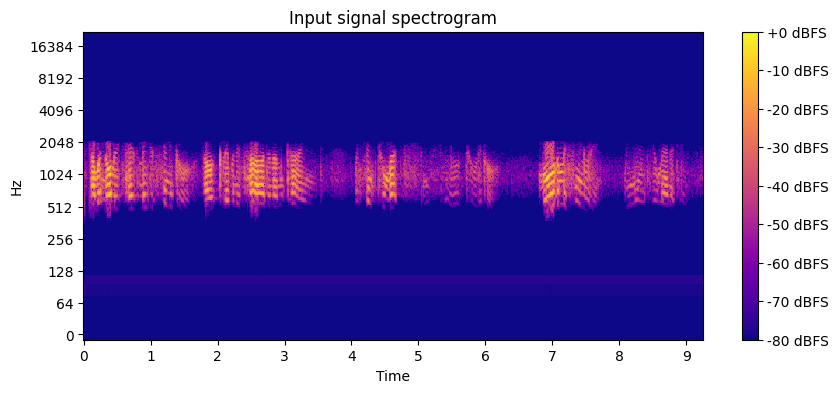

In [17]:
# Draw a spectrogram of the output signal

S = librosa.stft(filtered_signal)
magnitude = np.abs(S)
S_dBFS = librosa.amplitude_to_db(magnitude, ref=np.max)

# Plot the spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_dBFS, sr=sampleRate, x_axis='time', y_axis='log', cmap='plasma')
plt.colorbar(format='%+2.0f dBFS')
plt.title('Input signal spectrogram')
plt.show()

### When using the "Auto FIR filter"

We can now hear on the output file that the audio is much cleaner, which is also confirmed in the output signal plot, the signal FFT, and the spectrogram.  
We can still see a peak at 100Hz, but it's at -80dBfs, which is not audible compared to the rest of the signal.

### When using the "Set FIR filter"

The higher frequencies have disappeared, but the 100Hz noise is still present and audible.

### When using the "Gaussian FIR filter"

Nothing really changed compared to the input signal

### When using the "Triangular FIR filter"

The same observations can be made as with the "Set FIR filter"; The higher frequencies have disappeared, but the 100Hz noise is still present and audible.

### When using the "Square FIR filter"

We can see a cleaner output, The 100Hz noise is still present, but it's much less pronounced than with the other filter types.

## IIR filter

Now that we have a FIR filter, we can try to design an IIR filter to filter out the noise and keep the voice signal. The same frequencies of interest are used for the IIR filter, and we will use a Butterworth type filter design..

First, we can create a high-pass filter with a cut-off frequency of 500Hz, then we can create a low-pass filter with a cut-off frequency of 2000Hz.  
To create a band-pass filter, we can convolute the two filters together.

In [18]:
# IIR High-pass filter
fs = sampleRate
f0 = 500.0
iir_high = signal.iirfilter(12, f0, rp=1, rs=80, btype='highpass', ftype='butter', fs=fs, output='sos')


In [19]:
# IIR Low-pass filter
fs = sampleRate
f0 = 2000.0
iir_low = signal.iirfilter(12, f0, rp=1, rs=80, btype='lowpass', ftype='butter', fs=fs, output='sos')


In [20]:
# Convolution of the filters
iir_filter = np.concatenate((iir_high, iir_low))


Let's look at the transfer functions of the filters :

/var/folders/zr/jl29y_v93l5crkd13qmw8ywm0000gn/T/ipykernel_7138/1367385855.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.plot(w, 20 * np.log10(abs(h)), label="High-pass filter")
/var/folders/zr/jl29y_v93l5crkd13qmw8ywm0000gn/T/ipykernel_7138/1367385855.py:10: RuntimeWarning: divide by zero encountered in log10
  plt.plot(w, 20 * np.log10(abs(h)), label="IIR filter", linestyle='dotted')


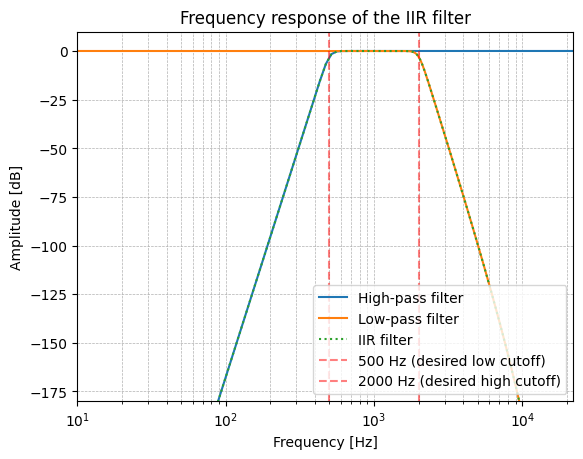

In [21]:
# Plot transfer functions of the filters
w, h = signal.sosfreqz(iir_high)
w = w * sampleRate / (2 * np.pi)
plt.plot(w, 20 * np.log10(abs(h)), label="High-pass filter")
w, h = signal.sosfreqz(iir_low)
w = w * sampleRate / (2 * np.pi)
plt.plot(w, 20 * np.log10(abs(h)), label="Low-pass filter")
w, h = signal.sosfreqz(iir_filter)
w = w * sampleRate / (2 * np.pi)
plt.plot(w, 20 * np.log10(abs(h)), label="IIR filter", linestyle='dotted')
plt.ylabel('Amplitude [dB]')
plt.xlabel('Frequency [Hz]')
plt.xscale('log')
plt.xlim([10, sampleRate/2])
plt.ylim([-180, 10])
plt.title('Frequency response of the IIR filter')
plt.axvline(500, color='red', linestyle='--', alpha=0.5, label='500 Hz (desired low cutoff)')
plt.axvline(2000, color='red', linestyle='--', alpha=0.5, label='2000 Hz (desired high cutoff)')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.legend(loc='lower right')
plt.show()

Now, let's apply the filters to the signal and listen to the output :

In [22]:
# Apply the filter to the input signal
filtered_samples = signal.sosfilt(iir_filter, samples_mono)

# Save file
sf.write('Data/speech_three-tones_filtered_iir.wav', filtered_samples, sampleRate)

In [23]:
# Show audio player
ipd.Audio("Data/speech_three-tones_filtered_iir.wav")

Finally, we can plot the filtered signal and its FFT and spectrogram.

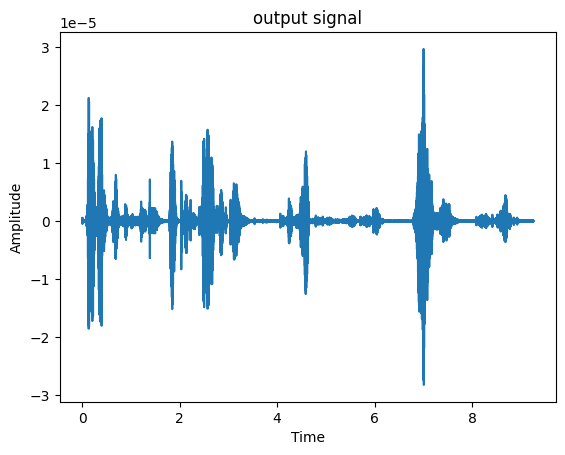

In [24]:
# Plot samples in time domain
bits = 16
max = float(2**(bits-1))
samples = filtered_samples / (max + 1)
time = np.arange(0, len(samples)/sampleRate, 1/sampleRate)
plt.plot(time, samples)
plt.title('output signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

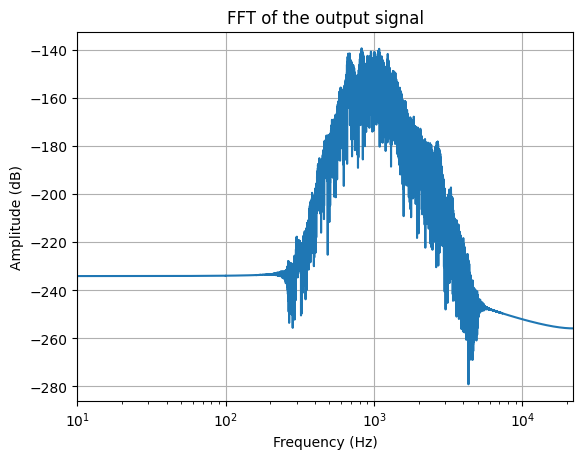

In [25]:
# Draw a FFT plot of the filtered signal
# Draw a FFT plot of the input signal using fft.fft
bits = 16
max = float(2**(bits-1))
samples = filtered_samples / (max + 1)
N = len(samples)
T = 1.0 / sampleRate
yf = fft.fft(samples)
xf = fft.fftfreq(N, T)[:N//2]
yf = 2.0/N * np.abs(yf[0:N//2])
plt.plot(xf, 20*np.log10(yf))
plt.grid()
plt.xscale('log')
plt.xlim([10, sampleRate/2])
plt.title('FFT of the output signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (dB)')
plt.show()

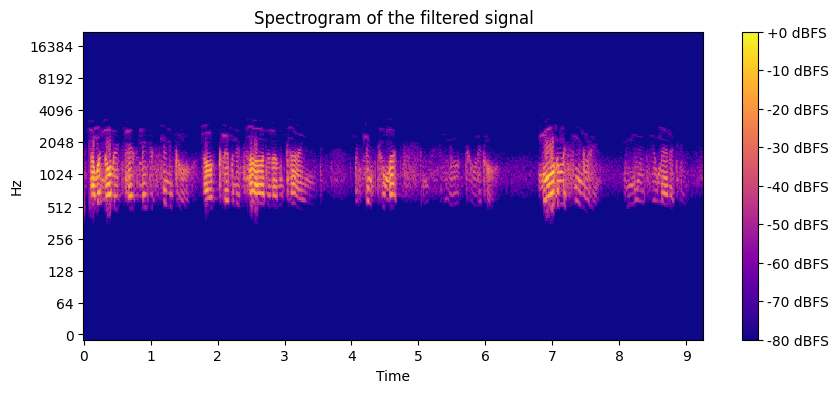

In [26]:
# Draw a spectrogram of the filtered signal

S = librosa.stft(filtered_samples)
magnitude = np.abs(S)
S_dBFS = librosa.amplitude_to_db(magnitude, ref=np.max)

# Plot the spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_dBFS, sr=sampleRate, x_axis='time', y_axis='log', cmap='plasma')
plt.colorbar(format='%+2.0f dBFS')
plt.title('Spectrogram of the filtered signal')
plt.show()

We can see that the output signal has successfully been filtered using both FIR and IIR filters. We can see that both filters have a similar performance, but the IIR filter has a slightly better performance in the stop-band region.

## Deciphering the message

If we listen to the filtered signal, we can hear that the voice signal is now much clearer, and the noises have been removed.  
If we listen closely, we can decipher the following message :

> Our knowledge has made us cynical. Our cleverness hard and unkind. We think too much, and feel too little. More than machinery, we need humanity.


## Comparison between analog, FIR, and IIR filters

Let's now compare analog, FIR, and IIR filters, using Butterworth and Chebyshev filter topologies.  
All the filters will have a cut-off frequency of 1000Hz, and a sampling rate of 44100Hz.

### Filter construction

First, we can create the low-pass analog filters (Butterworth and Chebyshev) :

In [80]:
# Parameters
fc = 1000
analog_order = 4

In [81]:
# Analog filters

# Butterworth analog filter

# Analog Butterworth low-pass filter of order 4 (fixed)
b_butter, a_butter = signal.butter(analog_order, 2 * np.pi * fc, btype='low', analog=True)

# Chebyshev type I analog filter
b_cheby, a_cheby = signal.cheby1(analog_order, 5, 2 * np.pi * fc, btype='low', analog=True)


Then, we can create the low-pass FIR filters

In [82]:
# FIR filter


nyq = sampleRate / 2  # Nyquist frequency

# The Nyquist rate of the signal.
nyq_rate = sampleRate / 2.0

# The desired width of the transition from pass to stop,
# relative to the Nyquist rate.  We'll design the filter
# with a x Hz transition width.
width = 300.0/nyq_rate
# The desired attenuation in the stop band, in dB.
stop_db = 60.0

# Compute the order and Kaiser parameter for the FIR filter.
numTaps, beta = signal.kaiserord(stop_db, width)

print('Amount of taps : ', numTaps)
fir_filter = signal.firwin(numtaps, cutoff=fc, fs=sampleRate, pass_zero='lowpass', window=('kaiser', beta))

Amount of taps :  534


Same for the IIR filters

In [83]:
# IIR Filters

iir_butter = signal.butter(analog_order, fc, btype='lowpass', analog=False, fs=sampleRate, output='sos')
iir_cheby = signal.cheby1(analog_order, 5, fc, btype='lowpass', analog=False, fs=sampleRate, output='sos')
iir_cheby3 = signal.cheby1(analog_order-1, 5, fc, btype='lowpass', analog=False, fs=sampleRate, output='sos')

Now, we cal plot all the transfer functions :

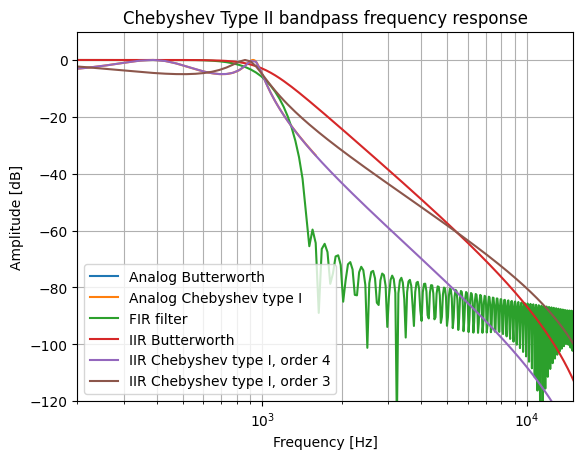

In [84]:
# Plot the filters

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
w, h = signal.freqs(b_butter, a_butter, 000)
ax.semilogx(w / (2*np.pi), 20 * np.log10(np.maximum(abs(h), 1e-5)), label='Analog Butterworth')
w, h = signal.freqs(b_cheby, a_cheby, 4000)
ax.semilogx(w / (2*np.pi), 20 * np.log10(np.maximum(abs(h), 1e-5)), label='Analog Chebyshev type I')
w, h = signal.freqz(fir_filter)
w = w * sampleRate / (2 * np.pi)
ax.semilogx(w, 20 * np.log10(abs(h)), label='FIR filter')
w, h = signal.sosfreqz(iir_butter)
w = w * sampleRate / (2 * np.pi)
ax.semilogx(w, 20 * np.log10(abs(h)), label='IIR Butterworth')
w, h = signal.sosfreqz(iir_cheby)
w = w * sampleRate / (2 * np.pi)
ax.semilogx(w, 20 * np.log10(abs(h)), label='IIR Chebyshev type I, order 4')
w, h = signal.sosfreqz(iir_cheby3)
w = w * sampleRate / (2 * np.pi)
ax.semilogx(w, 20 * np.log10(abs(h)), label='IIR Chebyshev type I, order 3')
ax.set_title('Chebyshev Type II bandpass frequency response')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Amplitude [dB]')
ax.grid(which='both', axis='both')
ax.legend()
# set limit to x axis
plt.xlim([200, 15000])
plt.ylim([-120, 10])
plt.show()


### General filter comparison

> We'll take the Analog Butterworth filter as a reference for the comparisons.

The analog Chebyshev filter has a steeper roll-off at the cut-off frequency than the Butterworth filter, but it has ripples in the passband. It then tends to the same slope as the butterworth filter in the stopband. Same thing can be said for the digital IIR Chebyshev filter.

Both analog and digital Chebyshev filters similar characteristics, as they have the same parameters.

The digital Butterworth IIR filter has the same characteristics as the analog Butterworth filter, though at higher frequencies the slope becomes steeper.

The FIR filter has a steeper roll-off than the analog Butterworth filter, but has a lot of ripple in the stopband. The roll-off starts les steep than the Chebychev filters, but becomes steeper really fast.

### Attenuation at 10*fc

When looking at 10*fc (10000Hz), we can see that the digital Chebyshev filter has the best attenuation, followed by the digital Butterworth filter, then the analog Butterworth filter. We could argue that the FIR filter has a better attenuation than the digital Butterworth filter, but it has a lot of ripple in the stopband.

### Ripple in bandpass

When looking at the bandpass, we can see that the analog and digital Chebyshev filter have a lot of ripple in the passband (5dB allowed in their construction parameters), followed by the FIR filter, which has nearly none. The digital and analog Butterworth filter has the least amount of ripple in the passband.

### Ripple in stopband

When looking at the stopband, we can see that the analog and digital Chebyshev and Butterworth filters have nearly no ripple. The FIR filter on the other hand, has a lot of ripple in the stopband.

### Filter Order

- The analog Butterworth and Chebychev filter has an order of 4, which is consistent with the asked specifications.
- The FIR filter requires a an order of 534 to achieve the desired attenuation.
- The digital Butterworth filter gets to the desired attenuation with a much lower order of 4, which demonstrates the efficiency of IIR filters.
- The digital Chebyshev can get to the same attenuation with an order of 3, which is even more efficient than the Butterworth filter, but xith the trade-off of having ripples in the passband.